In [1]:
from scaledyolov4.scaled_yolov4 import ScaledYOLOV4

In [2]:
import math
import pkg_resources

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from numpy.linalg import norm

%matplotlib inline

## Example

(1920, 1280, 3)


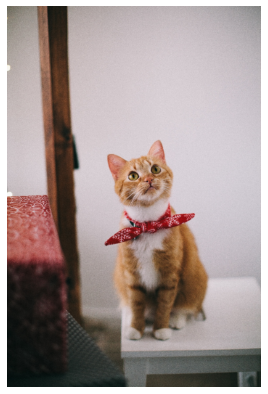

In [3]:
image = cv2.imread('images/image01.jpg')
print(image.shape)

plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.axis('off')
plt.show()

In [4]:
detector = ScaledYOLOV4(
    thresh=0.4,
    nms_thresh=0.5,
    bgr=True,
    gpu_device=0,
    model_image_size=608,
    max_batch_size=64,
    half=True,
    same_size=True,
    weights=pkg_resources.resource_filename('scaledyolov4', 'weights/yolov4l-mish_-state.pt'),
    cfg=pkg_resources.resource_filename('scaledyolov4', 'configs/yolov4-csp.yaml'),
)

Using CUDA device 0
Model Summary: 334 layers, 5.29248e+07 parameters, 5.29248e+07 gradients
Fusing layers... Model Summary: 235 layers, 5.2896e+07 parameters, 5.2896e+07 gradients
Warmed up!


([488, 669, 1013, 1695], 0.8414440155029297, 'cat')
([493, 1011, 945, 1212], 0.8286933898925781, 'tie')


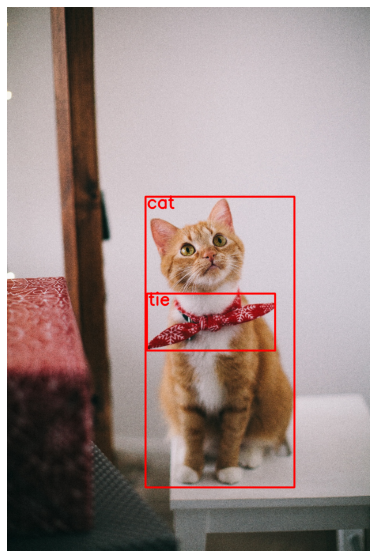

In [5]:
result = image.copy()

# change detector here (only display confident bboxes)
detections = detector.detect_get_box_in(image, box_format='ltrb')
for detection in detections:
    print(detection)
    bb, score, predicted_class = detection
    l,t,r,b = bb
    cv2.rectangle(result, (l,t), (r,b), (0,0,255), 5)
    cv2.putText(result, predicted_class, (l+5, t+40), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 5)

plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, ::-1])
plt.axis('off')
plt.show()

In [5]:
def generate_mask(image_size, grid_size, prob_thresh, rng):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.floor(image_w / grid_w), math.floor(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (rng.uniform(0, 1, size=(grid_h, grid_w)) < prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = rng.integers(0, cell_w, endpoint=True)
    offset_h = rng.integers(0, cell_h, endpoint=True)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [6]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) * 255).astype(np.uint8)
    return masked

In [7]:
#Intialise a random number generator
rng = np.random.default_rng(0)

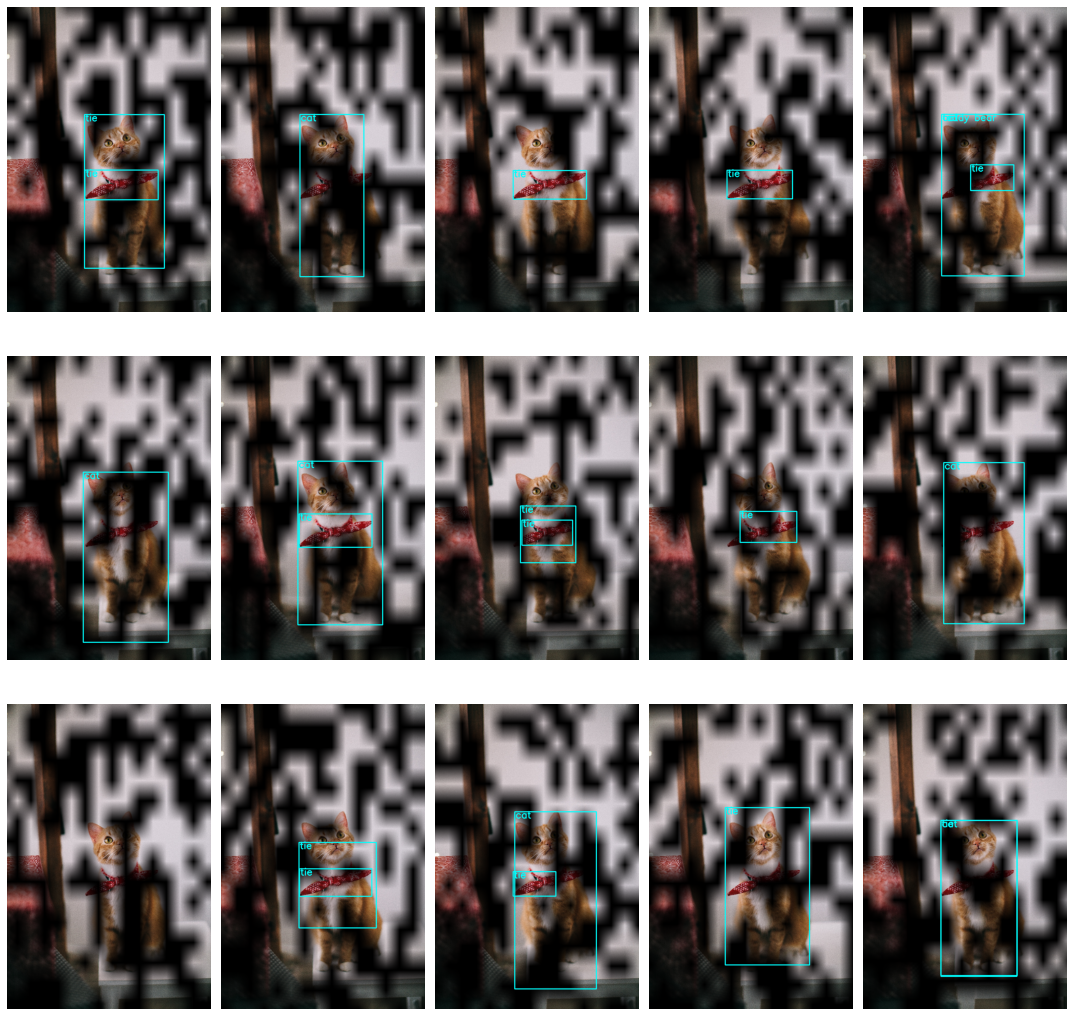

In [9]:
num_rows=3
num_cols=5

total_imgs = num_rows * num_cols
image_h, image_w = image.shape[:2]

all_masked = []
for _ in range(total_imgs):
    mask = generate_mask(
        image_size=(image_w, image_h),
        grid_size=(16, 16),
        prob_thresh=0.5,
        rng=rng)
    masked = mask_image(image, mask)
    all_masked.append(masked)

# change detector here (only display confident bboxes)
# detector output should be a List[List[([l, t, r, b], score, predicted_class)]]
all_detections = detector.detect_get_box_in(all_masked, box_format='ltrb')

images = []
for idx, image_detections in enumerate(all_detections):
    result = all_masked[idx].copy()
    for detection in image_detections:
        bb, score, predicted_class = detection
        l,t,r,b = bb
        cv2.rectangle(result, (l,t), (r,b), (255,255,0), 5)
        cv2.putText(result, predicted_class, (l+5, t+40), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,0), 5)
    images.append(result)

fig = plt.figure(figsize=(15, 15))
axes = fig.subplots(num_rows,num_cols)
for i in range(num_rows):
    for j in range(num_cols):
        axes[i][j].imshow(images[i * num_cols + j][:, :, ::-1])
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [8]:
def iou_batch(bbox1, bboxes2):
    bbox1 = np.asarray(bbox1)
    bboxes2 = np.asarray(bboxes2)
    x11, y11, x12, y12 = bbox1
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [9]:
def cosine_similarity(arr1, arr2):
    return np.dot(arr1, arr2) / (norm(arr1) * norm(arr2))

In [10]:
def similarity_metric(target_box, target_one_hot, detections):
    all_bboxes = detections[:, :4]
    all_objectness = detections[:, 4]
    all_cls_probs = detections[:, 5:]

    ious = iou_batch(target_box, all_bboxes).squeeze()
    cosines = cosine_similarity(all_cls_probs, target_one_hot)

    return np.max(ious * np.asarray(all_objectness) * cosines)

In [11]:
def generate_saliency_map(image, detector, target_cls_idx, target_box, num_classes, rng,
                          prob_thresh=0.5, grid_size=(16, 16), n_masks=5000, batch=True, max_batch=1000):
    image_h, image_w = image.shape[:2]

    target_one_hot = np.zeros(num_classes)
    target_one_hot[target_cls_idx] = 1

    mask_score = np.empty((image_h, image_w), dtype=np.float32)
    
    if batch:
        for i in range(0, n_masks, max_batch):
            num_masks_batch = min(i+max_batch, n_masks) - i

            all_masks = np.empty((num_masks_batch, image_h, image_w), dtype=np.float32)
            all_masked = []
            for idx in tqdm(range(num_masks_batch)):
                mask = generate_mask(
                    image_size=(image_w, image_h),
                    grid_size=grid_size,
                    prob_thresh=prob_thresh,
                    rng=rng)
                masked = mask_image(image, mask)
                all_masks[idx, :, :] = mask
                all_masked.append(masked)
            
            # change detector here (keep all bboxes regardless of confidence or class)
            # detector output should be a List[List[([l, t, r, b], score, predicted_class)]]
            all_detections = detector.detect_get_box_in(all_masked, box_format='ltrb', raw=True)

            all_scores = np.empty(num_masks_batch, dtype=np.float32)
            for idx, mask_detections in enumerate(all_detections):
                all_scores[idx] = similarity_metric(target_box, target_one_hot, mask_detections)
            mask_score_batch = np.tensordot(all_masks, all_scores, axes=(0,0))
            mask_score += mask_score_batch

    else:
        for _ in tqdm(range(n_masks)):
            mask = generate_mask(
                image_size=(image_w, image_h),
                grid_size=grid_size,
                prob_thresh=prob_thresh,
                rng=rng)
            masked = mask_image(image, mask)
            
            # change detector here (keep all bboxes regardless of confidence or class)
            # detector output should be a List[([l, t, r, b], score, predicted_class)]
            detections = detector.detect_get_box_in(masked, box_format='ltrb', raw=True)

            score = similarity_metric(target_box, target_one_hot, detections)
            mask_score += mask * score

    return mask_score

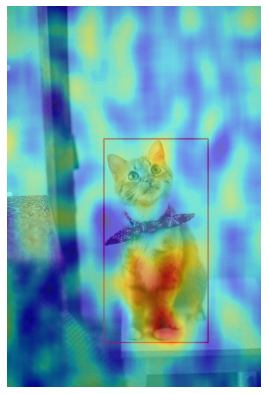

In [12]:
target_box = [488, 669, 1013, 1695]
target_class = 'cat'
# target_box = [493, 1011, 945, 1212]
# target_class = 'tie'

saliency_map = generate_saliency_map(
        image,
        detector,
        target_cls_idx=detector.classname_to_idx(target_class),
        target_box=target_box,
        num_classes = len(detector.class_names),
        rng=rng,
        grid_size=(16,16),
        prob_thresh=0.5,
        n_masks=1000,
        batch=True)

image_with_bbox = image.copy()
cv2.rectangle(image_with_bbox, tuple(target_box[:2]), tuple(target_box[2:]), (0, 0, 255), 5)
plt.figure(figsize=(7, 7))
plt.imshow(image_with_bbox[:, :, ::-1])
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()